# Map preprocessing

In [1]:
import networkx as nx
import osmnx as ox

In [2]:
#Load map
g=ox.graph_from_place('Paris, France', network_type='bike',simplify=False)
gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)

#Prune road types
remove_tags=['bridleway','path','unclassified','road']

del_list=[]
for j,i in gdf_edges.iterrows():
    if i["highway"] in remove_tags:
        del_list.append(j)
gdf_edges=gdf_edges.drop(index=del_list)
g=ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)  

#Rebuild the map
largest_cc = max(nx.strongly_connected_components(g), key=len)
g = g.subgraph(largest_cc)
gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)
gdf_edges=gdf_edges.droplevel(-1)

# Data generation

In [3]:
from DataGenerator import DataGenerator
import csv
import ast

from sklearn.model_selection import train_test_split

In [4]:
def save_data(samplings,tracks,append=False):
    mode = "a" if append else "w"

    with open("data/generated-data-samplings.csv", mode) as f:  
        writer = csv.writer(f, delimiter=';', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for sampling in samplings:
            writer.writerow(sampling)

    with open("data/generated-data-tracks.csv", mode) as f:  
        writer = csv.writer(f, delimiter=';', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for track in tracks:
            writer.writerow(track)

def load_data():
    with open('data/generated-data-samplings.csv', 'r') as f:
        samplings=[]
        for sampling in f:
            entries = sampling.strip().split(';')
            nested_lists = [ast.literal_eval(entry) for entry in entries]
            samplings.append(nested_lists)

    with open('data/generated-data-tracks.csv', 'r') as f:
        tracks=[]
        for track in f:
            entries = track.strip().split(';')
            nested_lists = [ast.literal_eval(entry) for entry in entries]
            tracks.append(nested_lists)
    return samplings, tracks

In [5]:
#Create the generator
path="data/comptage-velo-donnees-compteurs.csv"
datagen=DataGenerator(G=g,gdf_nodes_edges=(gdf_nodes,gdf_edges),data_path=path)

#Generate data in bacthes and save it to the generated data
# print("Data generation")
# generator_batch_size=100
# n_batches=10
# for batch in range(n_batches):
#     samplings,tracks=datagen.track_generator(generator_batch_size,sampling_rate=1)
#     save_data(samplings,tracks,append=True)

Loading data...
Linking stations to nodes...
Generating node masks...


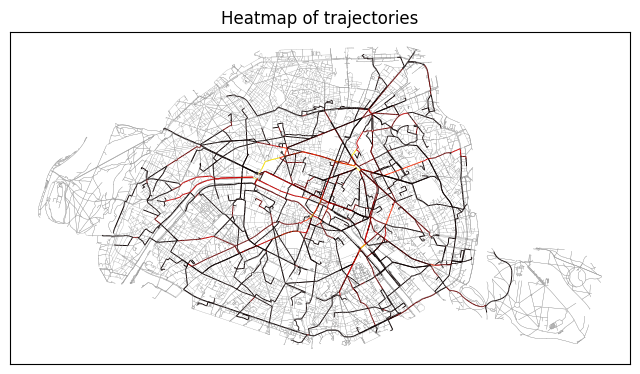

In [7]:
#Load the generated data
phi,T=load_data()
datagen.plot_heatmap(phi,
                     show_non_traversed=True,show_stations=False,
                     show_start=False,show_end=False,
                     legend=False,cmap='hot',bkg_color='w',dpi=100)

phi_train,phi_test,T_train,T_test=train_test_split(phi,T,train_size=0.8)

# Travel time distribution

In [7]:
baseline_TTD = ox.add_edge_speeds(g)
baseline_TTD = ox.add_edge_travel_times(baseline_TTD)

# Trajectory recovery

In [8]:
from collections import OrderedDict

In [9]:
def edges_to_nodes(track):
    return [edge[0] for edge in track]

def nodes_to_edges(track):
    return [(track[i],track[i+1]) for i in range(len(track)-1)]

In [10]:
def recover_route(track_sampling,recovery_algorithm,debug=False):

    edges= [(n1,n2) for t,n1,n2,e in track_sampling]
    unique_edges = list(OrderedDict.fromkeys(edges))

    edge_0=unique_edges[0]
    recovered_track=[edge_0]
    n_added_edges=0
    for edge_1 in unique_edges[1:]:
        if edge_1[0]!=edge_0[1]:
            recovered_path=recovery_algorithm(edge_0[1],edge_1[0])
            recovered_track+=recovered_path
            if debug:
                # print(f'Adding {len(recovered_path)} edges between {edge_0[1]} and {edge_1[0]}')
                n_added_edges+=len(recovered_path)
                
        recovered_track.append(edge_1)
        edge_0=edge_1

    if debug:
        print(f'Recovered track consists on {len(recovered_track)} edges, of which {n_added_edges} ({100*n_added_edges/len(recovered_track):.0f}%) were added.')

    return recovered_track

In [11]:
def recover_routes_from_samplings(samplings,recovery_algorithm,debug=False):
    return [recover_route(s,recovery_algorithm,debug=debug) for s in samplings]

## Algorithms

In [12]:
def baseline_recovery_algorithm(n1,n2):
    recovered_path=nx.shortest_path(g, n1, n2, weight='length')
    return nodes_to_edges(recovered_path)

In [13]:
def baseline_TTD_recovery_algorithm(n1,n2):
    recovered_path=nx.shortest_path(baseline_TTD, n1, n2, weight='travel_time')
    return nodes_to_edges(recovered_path)

## Recovery

In [14]:
T_hat_baseline=recover_routes_from_samplings(phi_test,baseline_recovery_algorithm)

T_hat_baseline_TTD=recover_routes_from_samplings(phi_test,baseline_TTD_recovery_algorithm)

# Clustering

In [15]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

from sklearn_extra.cluster import KMedoids

In [16]:
def row_wise_track_similarity(G,T):
    M=np.zeros((len(T),len(T)))
    G_aux=G.copy()

    for i,track_i in enumerate(T):

        G_aux.add_node("vSource")
        G_aux.add_edges_from(("vSource", n, {'length': 0}) for n in track_i)
        dists=nx.single_source_shortest_path_length(G_aux,"vSource")
        G_aux.remove_node("vSource")

        for j,track_j in enumerate(T):
            if i==j:
                continue
            
            max_dist=max(dists[m] for m in track_j)
                    
            M[i,j]=max_dist
    return M

In [17]:
def symmetrize(M,strategy='min'):
    if strategy=='mean':
        return (1/2)*(M+M.T)
    if strategy=='min':
        return np.minimum(M,M.T)
    if strategy=='max':
        return np.maximum(M,M.T)
    raise KeyError(f'{strategy} is not a valid strategy')

In [18]:
def k_corridors_medoid_summarizer(M,k,T,**kwargs):
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', **kwargs) #For example random_state=0
    kmedoids.fit(M)

    cluster_labels = kmedoids.labels_
    medoid_indices = kmedoids.medoid_indices_
    d=kmedoids.inertia_

    k_corridors=[T[i] for i in medoid_indices]
    return k_corridors,medoid_indices,cluster_labels

In [19]:
M_dict={}
paths_dict={}

#Compute the similarity matrix
paths_hat_baseline=[edges_to_nodes(track) for track in T_hat_baseline]
M_baseline=row_wise_track_similarity(g,paths_hat_baseline)
M_baseline=symmetrize(M_baseline,strategy='min')
M_dict['baseline']=M_baseline
paths_dict['baseline']=paths_hat_baseline

In [29]:
n_clusters=8

clustering_dict={}
for key,M in M_dict.items():
    T=paths_dict[key]
    clustering=k_corridors_medoid_summarizer(M,n_clusters,T,random_state=42)
    clustering_dict[key]=clustering #k_corridors,k_index,cluster_labels

# Evaluation

## k-metrics
For k-metrics, we compare an evaluation parameter with _all_ k corridors at once. I.e., for a track we don't evaluate if there is an intersection with a corridor but with _all_ of them

In [30]:
def k_absolute_intersect(track_i,k_tracks):
    """
    Returns 1 if there is at least one edge from track_i present in k_tracks,
    and 0 otherwise
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))

    for track_j in k_tracks:
        set_j=set(nodes_to_edges(track_j))

        #Calculate intesection
        intersect=set_i.intersection(set_j)
        n=len(intersect)
        if n!=1:
            return 1
    
    return 0
    

In [31]:
def k_relative_intersect(track_i,k_tracks):
    """
    Returns what portion of the edges from track_i are present in k_tracks
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))
    k_edges=np.concatenate([nodes_to_edges(track_j) for track_j in k_tracks])
    set_j=set([(n1,n2) for n1,n2 in k_edges])

    #Calculate intesection
    intersect=set_i.intersection(set_j)
    n=len(intersect)
    
    return n/len(set_i)

In [32]:
def k_lenght_relative_intersect(track_i,k_tracks,G):
    """
    Returns what portion of the length of track_i is in the cummulative length of the edges
    also present in k_tracks
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))
    k_edges=np.concatenate([nodes_to_edges(track_j) for track_j in k_tracks])
    set_j=set([(n1,n2) for n1,n2 in k_edges])

    #Calculate intersection
    intersect=set_i.intersection(set_j)

    l_intersect=sum([G.get_edge_data(*edge)[0]['length'] for edge in intersect])
    l_i=sum([G.get_edge_data(*edge)[0]['length'] for edge in set_i])


    
    return l_intersect/l_i

In [33]:
def evaluate_k_metric(metric_fun,T,k_corridors,**kwargs):
    """
    Returs the cummulative value (normalized by the number of tracks) of the 
    selected metric for the selected k corridors.
    T: A list of tracks to be evaluated (if k_corridors are included they will also be evaluated)
    k_corridors: A list of k selected corridors
    metric_fun: The metric function to evaluate as metric_fun(T[i],k_corridors[j],**kwargs)
    """

    result=0
    for track_i in T:
        result+=metric_fun(track_i,k_corridors,**kwargs)

    result/=len(T)

    return result

## M-metrics
M-metrics apply a matrix operation to the set of tracks and clusters

In [34]:
def evaluate_M(G,T,cluster_labels,k_index,sym_strategy=None):
        M=row_wise_track_similarity(G,T)
        if sym_strategy:
            M=symmetrize(M,strategy=sym_strategy)

        d=np.min(M[:,k_index],axis=1).sum()
        return d

In [35]:
def M_similarity(G,T,cluster_labels,k_index,include_corridors=False,ponderated=True,ponderation_k=1):
    '''
    This metric returns a metric based on the average similarity distance from
    the tracks to the corridors.
    If include_corridors, the average is made taking into consideration the corridors
    as tracks too, otherwise the average is made using only the rest of the tracks.
    
    If ponderated, the result is ponderated so that the metric ranges (0,1],
    where 1 means all tracks are corridors and 0 tracks are at an infinite distance from the corridors.
    The ponderation is k/(k+d), where k is the ponderation parameter that defines at which d
    the ponderated score is equal to 1/2
    '''

    d=evaluate_M(G,T,cluster_labels,k_index)
    n=len(T)
    if not include_corridors:
        n-=len(k_index)
    d/=n
    if ponderated:
        return ponderation_k/(ponderation_k+d)
    return d

## Evaluate

In [36]:
for key,clustering in clustering_dict.items():
    k_corridors,k_index,cluster_labels=clustering

    print(f'\n\n------------------\n\t{key}\t\n------------------')

    print("\nk-set metrics:\n--------------")

    abs_inter=evaluate_k_metric(k_absolute_intersect,T,k_corridors)
    print("Absolute intersection: {:.2f}".format(abs_inter))

    rel_inter=evaluate_k_metric(k_relative_intersect,T,k_corridors)
    print("Relative intersection: {:.2f}".format(rel_inter))

    l_rel_inter=evaluate_k_metric(k_lenght_relative_intersect,T,k_corridors,G=g)
    print("Length intersection: {:.2f}".format(l_rel_inter))

    print("\nM metrics:\n----------")

    m_sim=M_similarity(g,T,cluster_labels,k_index,ponderated=False,include_corridors=True)
    print("M average distance: {:.0f}m".format(m_sim))

    m_sim=M_similarity(g,T,cluster_labels,k_index,ponderated=True,include_corridors=True)
    print("Ponderated M similarity: {:.4f}".format(m_sim))



------------------
	baseline	
------------------

k-set metrics:
--------------
Absolute intersection: 1.00
Relative intersection: 0.44
Length intersection: 0.44

M metrics:
----------
M average distance: 64m
Ponderated M similarity: 0.0153
